# STK-IN9300- Mandatory assignment 2 of 2

**Author**: Anna Lina Sjur

**Acknowledgement**: I have used ChatGPT as a tool for programming (not for text generation). I have made sure to check the docmentation for the modules and methods I have used, and the content of this notebook reflects my own knowledge. 


This document reads best as HTML, which is available [here](https://github.com/alpsjur?tab=repositories).

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# I will use pygam for general additative models
from pygam import LogisticGAM, LinearGAM, s

# I will use statmodels for OLS models (it has some nice functionality, like summary tables)
import statsmodels.api as sm

# For estimating distributions
from scipy.stats import gaussian_kde

# I will use sklearn for remaining models and methods
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, \
    cross_val_score, LeaveOneOut
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, \
    plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import KNNImputer
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.neural_network import MLPClassifier

# use seaborn to make pretty plots 
import seaborn as sns
sns.set_theme("notebook")

# set universal figure size
figsize = (10,8)

## Problem 1 - Regression 🐟💀

For the regression problems, we will work with the dataset `qsar_aquatic_toxicity.csv`. We start by reading in the data and store it in a dataframe `df_i`, with the naming antisipating the two sub-problems in (a). We will use Mean Squared Error (MSE) as a messure of error. 

In [2]:
# Reading in data
variables = ["TPSA", "SAacc", "H050", "MLOGP", 
             "RDCHI", "GATS1p", "nN", "C040"]
response = "LC50"

# Initialize dictionary to store test results from different methods
test_results = {}
training_results = {}


df_i = pd.read_csv("qsar_aquatic_toxicity.csv", 
                   delimiter=";", 
                   names=variables+[response])
df_i

,TPSA,SAacc,H050,MLOGP,RDCHI,GATS1p,nN,C040,LC50
0,0.00,0.000,0,2.419,1.225,0.667,0,0,3.740
1,0.00,0.000,0,2.638,1.401,0.632,0,0,4.330
2,9.23,11.000,0,5.799,2.930,0.486,0,0,7.019
3,9.23,11.000,0,5.453,2.887,0.495,0,0,6.723
4,9.23,11.000,0,4.068,2.758,0.695,0,0,5.979
...,...,...,...,...,...,...,...,...,...
541,24.06,35.776,2,3.326,2.837,0.849,2,0,4.651
542,9.23,11.000,0,3.275,2.727,0.874,0,0,3.953
543,0.00,0.000,0,5.165,3.111,0.732,0,0,6.219
544,13.14,9.507,0,2.859,2.614,0.827,0,0,4.995


We then make a second dataframe `df_ii` where the count variables are translated to a binary value, where 0 represents 0 counts and 1 represents 1 or more counts. 

In [3]:
numeric_variables = ["H050", "nN", "C040"]
def binary_encoding(n):
    return np.where(n > 0, 1, 0)

df_ii = df_i.copy()
df_ii[numeric_variables] = df_i[numeric_variables].map(binary_encoding)

### (a) - Linear regression models 📈➖

We start by splitting the data into test and training sets. We will then train and evaluate an ordinary least squares model on both `df_i` and `df_ii` and report the results.

In [4]:
df_train_i, df_test_i, df_train_ii, df_test_ii = train_test_split(df_i, df_ii, 
                                                                  test_size=1/3, 
                                                                  random_state=2024
                                                                  )

In [5]:
# define functoin for training and evaluating OLS
def train_and_evaluate_ols(df_train, df_test, print_evaluation=True):
    # Add a constant / intercept
    X_train_with_intercept = sm.add_constant(df_train[variables])
    X_test_with_intercept = sm.add_constant(df_test[variables])

    # Fit the OLS model
    ols_model = sm.OLS(df_train[response], X_train_with_intercept).fit()

    # Calculate predictions
    y_train_pred = ols_model.predict(X_train_with_intercept)
    y_test_pred = ols_model.predict(X_test_with_intercept)

    # Calculate training and test errors
    train_error = mean_squared_error(df_train[response], y_train_pred)
    test_error = mean_squared_error(df_test[response], y_test_pred)

    if print_evaluation:
        # print built-in summary table
        print(ols_model.summary(),"\n")
    
        # Print the training and test errors
        print(f"Training MSE: {train_error:.4f}")
        print(f"Test MSE:     {test_error:.4f}")
        
    return test_error, train_error
    

#### (i)

In [6]:
print("OLS with original count values")
ols_test_mse, ols_train_mse = train_and_evaluate_ols(df_train_i, df_test_i)
test_results["OLS"] = np.mean(ols_test_mse)
training_results["OLS"] = np.mean(ols_train_mse)

OLS with original count values
                            OLS Regression Results                            
Dep. Variable:                   LC50   R-squared:                       0.445
Model:                            OLS   Adj. R-squared:                  0.433
Method:                 Least Squares   F-statistic:                     35.62
Date:                Thu, 24 Oct 2024   Prob (F-statistic):           3.26e-41
Time:                        18:30:04   Log-Likelihood:                -575.71
No. Observations:                 364   AIC:                             1169.
Df Residuals:                     355   BIC:                             1204.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.6872

The t column gives the t-statistic for each coefficient, and P>|t| provides the corresponding p-value. Typically, a p-value less than 0.05 indicates that the coefficient is significant. Thus, the p-values suggests that the variables `H050` and `C040` are not significant. The variables `RDCHI` and `GATS1p` have corresponding p-values below 0.05, but are boarderline cases. 

Regarding the test and training error, we see that the MSE goes up for the test set. This illustrates the need for an independent test set. 

#### (ii)

In [7]:
print("OLS with binary mapped count values")
train_and_evaluate_ols(df_train_ii, df_test_ii);

OLS with binary mapped count values
                            OLS Regression Results                            
Dep. Variable:                   LC50   R-squared:                       0.426
Model:                            OLS   Adj. R-squared:                  0.413
Method:                 Least Squares   F-statistic:                     32.94
Date:                Thu, 24 Oct 2024   Prob (F-statistic):           1.22e-38
Time:                        18:30:04   Log-Likelihood:                -581.92
No. Observations:                 364   AIC:                             1182.
Df Residuals:                     355   BIC:                             1217.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2

Let's start with the significance of the regression coefficients. First of all, the p-values now suggests that more variales are not significant, compared to the results for (i). Now, in addition to `H050` and `C040`, the variable `nN` also has a p-value over 0.05. Interestingli, the p-value for `RDCHI` also increases to over 0.05, even though this is not a count variable. This illustrates that transforming one variable can affect statistics for other variables. 

When it comes to the errors, we see that both the training and test errors increases compared to (i). 

### (b) - Distribution of test error for OLS 📊🔄 

We will repeat what we did in (a) 200 times, record the test error, and use a kernel density estimate to illustrate the distribution of the test errors.

In [8]:
n = 200

# initiate arrays to store the results
test_error_i = np.zeros(n)
test_error_ii = np.zeros(n)

# split, train and evaluate an ols model n times
for i in range(n):
    df_train_i_temp, df_test_i_temp, df_train_ii_temp, df_test_ii_temp = \
        train_test_split(df_i, df_ii, test_size=1/3, random_state=i)
    test_error_i[i] = train_and_evaluate_ols(df_train_i_temp, 
                                             df_test_i_temp, 
                                             print_evaluation=False)[0]
    test_error_ii[i] = train_and_evaluate_ols(df_train_ii_temp, 
                                              df_test_ii_temp, 
                                              print_evaluation=False)[0]

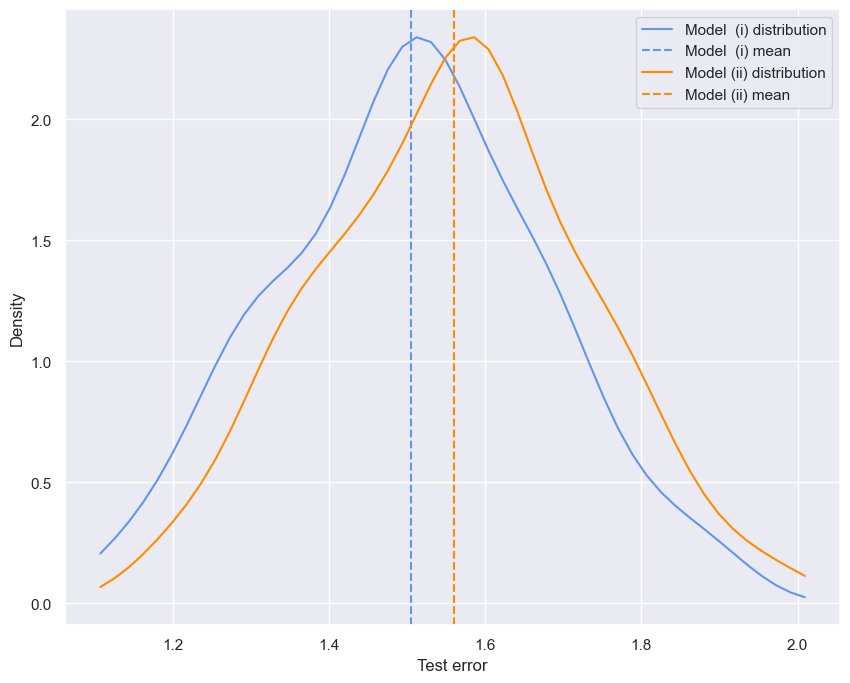

In [9]:
# Perform KDE using scipy's gaussian_kde
kde_i = gaussian_kde(test_error_i)
kde_ii = gaussian_kde(test_error_ii)

# Generate values over which to evaluate the KDE
x = np.linspace(np.min([np.min(test_error_i), np.min(test_error_ii)]), 
                np.max([np.max(test_error_i), np.max(test_error_ii)]))

# Plot distributions
fig, ax = plt.subplots(figsize=figsize)

ax.plot(x, kde_i(x), 
        color="cornflowerblue", 
        label="Model  (i) distribution"
        )
ax.axvline(np.mean(test_error_i), 
           color="cornflowerblue", 
           ls="--", 
           label="Model  (i) mean"
           )

ax.plot(x, kde_ii(x), 
        color="darkorange", 
        label="Model (ii) distribution"
        )
ax.axvline(np.mean(test_error_ii), 
           color="darkorange", 
           ls="--", 
           label="Model (ii) mean"
           )

ax.set_ylabel("Density")
ax.set_xlabel("Test error")
ax.legend()

As we see from the distributions above, test error distributions for differnt methods can overlap, even though the means are differnt. It is clear from the distributions that model (i) is preferable over model (ii). However, if we would have preformed just one experiment, there is a considerable chance that the test error for model (ii) would be lower than for model (i). Thus, we should preform the evaluation multiple times to make more informed decissions. 

So why do we obtain a wore result by using model (ii)? My initial tought is that the usefullness of binary encodings is highly problem-dependent. I believe that there are few situations where a response is dependent on wether "something" is present or not, but not on the amount of "something". Rather, in most physical systems, the effect of "something" is strengthened as "something" increases itself. thus, in general, keeping the original count as a variable gives better results.

For the remaining problems, I will use the original dataset `df_i`.

### (c) - Variable selection for OLS 🎛️🔢

I will apply backward elimination and forward selection, and use both AIC and BIC as stopping criterias, to reduce the number of variables.

In [10]:
def backward_elimination(df, variables, response, criterion="AIC"):
    # Train initial model
    X = sm.add_constant(df[variables])
    model = sm.OLS(df[response], X).fit()
    
    # Get initial model score
    if criterion=="AIC":
        score = model.aic
    elif criterion=="BIC":
        score = model.bic
    else:
        raise Exception("Invalid stopping criterion. \
            Must be ""AIC"" or ""BIC""")

    current_variables = variables
    best_score = score
    
    # remove variables until score no longer improves 
    # or there is only one variable left
    while score <= best_score and len(current_variables) > 1:
        # update best options
        best_model = model
        best_score = score
        best_variables = current_variables
        
        # Try removing each variable one by one and calculate AIC/BIC
        removal_results = []
        for var2drop in current_variables:  
            vars_temp = [var for var in current_variables if var != var2drop]
            X_temp = df[vars_temp]
            X_temp = sm.add_constant(X_temp)
            model_temp = sm.OLS(df[response], X_temp).fit()
            if criterion == 'AIC':
                new_score = model_temp.aic 
            else: 
                new_score = model_temp.bic
                
            removal_results.append((new_score, var2drop, model_temp))
        
        # Find the best model by minimizing the AIC/BIC
        removal_results.sort(key=lambda x: x[0])
        score, worst_variable, model = removal_results[0]
        
        # Remove worst variable 
        current_variables = [var for var in current_variables \
            if var != worst_variable]

    
    removed_variables = [var for var in variables \
        if var not in best_variables]
    
    # Spesial case where no variabkes were removed
    if len(removed_variables)==0:
        removed_variables.append("none")
    
    return best_model, removed_variables


In [11]:
def forward_selection(df, variables, response, criterion="AIC"):
    # Train initial model with only intercept
    X = np.ones(len(df[response]))
    model = sm.OLS(df[response], X).fit()
    
    # Get initial model score
    if criterion=="AIC":
        score = model.aic
    elif criterion=="BIC":
        score = model.bic
    else:
        raise Exception("Invalid stopping criterion. Must be ""AIC"" or ""BIC""")
   
    remaining_variables = variables 
    current_variables = []
    best_score = score

    # add variables until score no longer improves or all variables are included
    while score <= best_score and len(current_variables) < len(variables):
        best_model = model
        best_score = score
        best_variables = current_variables
        
        # Try adding each variable one by one and calculate AIC/BIC
        addition_results = []
        for var2add in remaining_variables: 
            X_temp = sm.add_constant(df[current_variables+[var2add]])
            model_temp = sm.OLS(df[response], X_temp).fit()
            new_score = model_temp.aic if criterion == 'AIC' else model_temp.bic

            addition_results.append((new_score, var2add, model_temp))
        
        # Find the best model by minimizing the AIC/BIC
        addition_results.sort(key=lambda x: x[0])
        score, best_variable, model = addition_results[0]
        
        current_variables = current_variables + [best_variable]
        remaining_variables = [var for var in remaining_variables if var != best_variable]

    
    removed_variables = [var for var in variables if var not in best_variables]
    if len(removed_variables)==0:
        removed_variables.append("none")
    
    return best_model, removed_variables


In [12]:
# Run elimination methods and print result
best_model_backward_aic, removed_vars_aic = backward_elimination(
    df_train_i, variables, response, 
    criterion='AIC')
print(f"Backward elimination with AIC removed: \
    {', '.join(removed_vars_aic)}")

best_model_backward_bic, removed_vars_bic = backward_elimination(
    df_train_i, variables, response, 
    criterion='BIC')
print(f"Backward elimination with BIC removed: \
    {', '.join(removed_vars_bic)}")

best_model_forward_aic, removed_vars_aic = forward_selection(
    df_train_i, variables, response, 
    criterion='AIC')
print(f"Forward selection with AIC removed   : \
    {', '.join(removed_vars_aic)}")

best_model_forward_bic, removed_vars_bic = forward_selection(
    df_train_i, variables, response, 
    criterion='BIC')
print(f"Forward selection with BIC removed   : \
    {', '.join(removed_vars_bic)}")

Backward elimination with AIC removed:     H050, C040
Backward elimination with BIC removed:     H050, RDCHI, GATS1p, C040
Forward selection with AIC removed   :     H050, C040
Forward selection with BIC removed   :     H050, RDCHI, GATS1p, C040


We see that both backward elimination and forward selection give the same results for this problem, as long as they have the same stopping criteria. Futher, BIC seems to be a stricter criteria, since it removes more variables. Thus, we end up with two different sets of variables, giving two different models. 

Comparing with reults from (a.i), we see that the least significant variables are removed. 

In [13]:
# Evaluate OLS with AIC criterion
aic_vars = [var for var in variables if var not in removed_vars_aic]

X_test_aic = sm.add_constant(df_test_i[aic_vars])
mse_OLS_AIC = mean_squared_error(
    best_model_backward_aic.predict(X_test_aic), df_test_i[response])
test_results["OLS aic\nselection"] = mse_OLS_AIC
print(f"Test MSE for AIC criterion variable reduction: {mse_OLS_AIC:.4f}")

X_train_aic = sm.add_constant(df_train_i[aic_vars])
mse_OLS_AIC = mean_squared_error(
    best_model_backward_aic.predict(X_train_aic), df_train_i[response])
training_results["OLS aic\nselection"] = mse_OLS_AIC

# Evaluate OLS with BIC criterion
bic_vars = [var for var in variables if var not in removed_vars_bic]

X_test_bic = sm.add_constant(df_test_i[bic_vars])
mse_OLS_BIC = mean_squared_error(
    best_model_backward_bic.predict(X_test_bic), df_test_i[response])
test_results["OLS bic\nselection"] = mse_OLS_BIC
print(f"Test MSE for BIC criterion variable reduction: {mse_OLS_BIC:.4f}")

X_train_bic = sm.add_constant(df_train_i[bic_vars])
mse_OLS_BIC = mean_squared_error(
    best_model_backward_bic.predict(X_train_bic), df_train_i[response])
training_results["OLS bic\nselection"] = mse_OLS_BIC

Test MSE for AIC criterion variable reduction: 1.5407
Test MSE for BIC criterion variable reduction: 1.6538


For reference, including all variables gave a MSE of 1.5458 (from task a.i). As we see, decreasing the model complexity with two variables (given by AIC) reduses the test error. However, further reducing the model complexity by removing two more variables (given by BIC) increases the model error again. 

On that note, we learned from (b) that doing a single test can be misleading, so these numbers should be taken with a grain of salt.  

### (d) - Ridge regression tuned with bootstrap and k-folds cross-validation ⛰️

We will apply ridge regression und use both a boothstrapping method and k-folds cross-validation to find the optimal alpha-variable. We will use 10 folds for the cross vaidation.  

In [14]:
# preprocess data for Ridge regression
# Normalize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(df_train_i[variables])
X_test_scaled = scaler.transform(df_test_i[variables])

In [15]:
# Define a grid of alpha values 
#alpha_grid = np.logspace(-4, 4, 100) # Broad sweep
alpha_grid = np.linspace(0,20, 201)   # refined sweep based on result from initial broad sweep

In [16]:
# K-fold cross validation, using 10 folds
kfold = KFold(n_splits=10, shuffle=True, random_state=2024)

# Use GridSearchCV to find the best alpha using cross-validation
ridge_cv = GridSearchCV(Ridge(), 
                        param_grid={'alpha': alpha_grid}, 
                        scoring='neg_mean_squared_error', 
                        cv=kfold)
ridge_cv.fit(X_train_scaled, df_train_i[response])

# Get the best alpha
best_alpha_cv = ridge_cv.best_params_['alpha']

# Cross-validation MSE, convert negative MSE to positive 
cv_mse = -ridge_cv.cv_results_['mean_test_score']  

print(f"Best alpha using cross-validation: {best_alpha_cv:.2f}")

Best alpha using cross-validation: 2.50


In [17]:
# Function to compute MSE for multiple alphas using boothstrap method
def bootstrap_ridge(X, y, alpha_grid, n_bootstraps=100):
    bootstrap_mse = np.zeros(len(alpha_grid))

    # Perform bootstrapping
    for i in range(n_bootstraps):
        # Resample the data (with replacement)
        Xi, yi = resample(X, y, random_state=i)
        
        # Identify OOB (out of bag) samples for testing
        oob_mask = ~np.isin(np.arange(len(y)), 
                            resample(np.arange(len(y)), random_state=i))
        Xoob, yoob = X[oob_mask], y[oob_mask]
        
        # Skip iteration if no OOB samples exist (Very unlikely?)
        if len(Xoob) == 0:
            continue

        # Compute the MSE for each alpha
        mse_per_alpha = []
        for alpha in alpha_grid:
            ridge = Ridge(alpha=alpha)
            ridge.fit(Xi, yi)
            y_pred = ridge.predict(Xoob)                 
            mse = mean_squared_error(yoob, y_pred)
            mse_per_alpha.append(mse)
        
        # Add MSE for each alpha to bootstrap MSE sum
        bootstrap_mse += np.array(mse_per_alpha)

    
    # Average MSE over all bootstrap samples
    bootstrap_mse /= n_bootstraps
    
    return bootstrap_mse

# Perform bootstrapping
bootstrap_mse = bootstrap_ridge(X_train_scaled, 
                                df_train_i[response], 
                                alpha_grid)

# Get the best alpha
best_alpha_bootstrap = alpha_grid[np.argmin(bootstrap_mse)]
print(f"Best alpha using Bootstrap: {best_alpha_bootstrap:.2f}")

Best alpha using Bootstrap: 5.70


Text(0, 0.5, 'MSE')

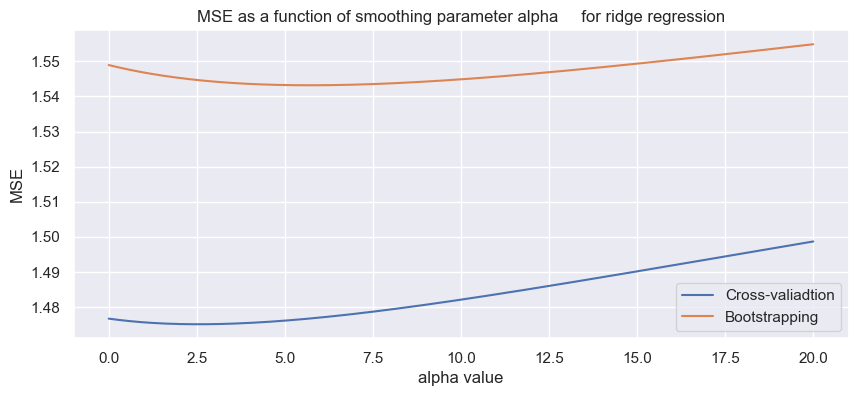

In [18]:
# Plot MSE as function of alpha
fig, ax = plt.subplots(figsize=(figsize[0], figsize[1]/2))

ax.plot(alpha_grid, cv_mse, label="Cross-valiadtion")
ax.plot(alpha_grid, bootstrap_mse, label="Bootstrapping")

ax.legend()
ax.set_title("MSE as a function of smoothing parameter alpha \
    for ridge regression")
ax.set_xlabel("alpha value")
ax.set_ylabel("MSE")
#ax.set_ylim(0, None)

As we see from the figure above, 10-folds cross-validation and bootstrapping gives similar, but not the same, optimal alpha value for ridge regression. We also see that the two methods estimate different MSEs, with bootstrapping giving a higher MSE. 

Let's see what the test error is for the different methods:

In [19]:
# Calculating testing and training errors for the different procedures
ridge_cv = Ridge(alpha=best_alpha_cv)
ridge_cv.fit(X_train_scaled, df_train_i[response])
y_pred_cv = ridge_cv.predict(X_test_scaled)
mse_ridge_cv = mean_squared_error(y_pred_cv, df_test_i[response])
test_results["Ridge cv"] = mse_ridge_cv
print(f"Test MSE for Ridge tuned with cross-validation: \
    {mse_ridge_cv:.4f}")

y_pred_cv = ridge_cv.predict(X_train_scaled)
mse_ridge_cv = mean_squared_error(y_pred_cv, df_train_i[response])
training_results["Ridge cv"] = mse_ridge_cv

ridge_bs = Ridge(alpha=best_alpha_bootstrap)
ridge_bs.fit(X_train_scaled, df_train_i[response])
y_pred_bs = ridge_bs.predict(X_test_scaled)
mse_ridge_bs = mean_squared_error(y_pred_bs, df_test_i[response])
test_results["Ridge bootstrap"] = mse_ridge_bs
print(f"Test MSE for Ridge tuned with Bootstrap:        \
    {mse_ridge_bs:.4f}")

y_pred_bs = ridge_bs.predict(X_train_scaled)
mse_ridge_bs = mean_squared_error(y_pred_bs, df_train_i[response])
training_results["Ridge bootstrap"] = mse_ridge_bs

Test MSE for Ridge tuned with cross-validation:     1.5566
Test MSE for Ridge tuned with Bootstrap:            1.5725


As we see, both tuning methods gives similar MSEs. Comparing with the plot above, the MSE given by the bootstrap method is closer to the test error. 

### (e) - Generalised additive model 📈➕

We will fit GAMs using smoothing splines for each variable, using the module `pyGAM`. The complexity of the splines can be adjusted by changing the `lam` parameter. The standard value for `lam` is 0.6. Decreasing `lam` decreases the smoothing and increases the complexity, while increasing `lam` increases the smoothing and decreases the complexity.

In [20]:
def fit_GAM(df_train, df_test, X_train, X_test, response, lam=0.6):
    # Fit a GAM model with 8 variables
    gam = LinearGAM(s(0, lam=lam) + s(1, lam=lam) + 
                    s(2, lam=lam) + s(3, lam=lam) + 
                    s(4, lam=lam) + s(5, lam=lam) + 
                    s(6, lam=lam) + s(7, lam=lam)
                    ).fit(X_train, df_train[response])
    
    # Predict on test set and calculate mse
    y_pred_test = gam.predict(X_test)
    mse_test = mean_squared_error(df_test[response], y_pred_test)


    # Predict on training set as well and calculate mse
    y_pred_train = gam.predict(X_train)
    mse_train = mean_squared_error(df_train[response], y_pred_train)
    
    return gam, mse_test, mse_train


In [21]:
# Standardize the variables
scaler = StandardScaler()
X_train = scaler.fit_transform(df_train_i[variables])
X_test = scaler.transform(df_test_i[variables])

In [22]:
gam_default, mse_test_default, mse_train_default = fit_GAM(
    df_train_i, df_test_i, X_train, X_test, response)

print(f'MSE for training set with default smoothing: \
    {mse_train_default:.4f}')
print(f'MSE for test set with default smoothing:     \
    {mse_test_default:.4f}')

print("\n")

gam_complex, mse_test_complex, mse_train_complex = fit_GAM(
    df_train_i, df_test_i, X_train, X_test, response, lam=0.1)

print(f'MSE for training set with less smoothing:    \
    {mse_train_complex:.4f}')
print(f'MSE for test set with less smoothing:        \
    {mse_test_complex:.4f}')

print("\n")

gam_smooth, mse_test_smooth, mse_train_smooth = fit_GAM(
    df_train_i, df_test_i, X_train, X_test, response, lam=10)

print(f'MSE for training set with more smoothing:    \
    {mse_train_smooth:.4f}')
print(f'MSE for test set with more smoothing:        \
    {mse_test_smooth:.4f}')

test_results["GAM default\nsmoothing"] = mse_test_default 
test_results["GAM less\nsmoothing"] = mse_test_complex 
test_results["GAM more\nsmoothing"] = mse_test_smooth 

training_results["GAM default\nsmoothing"] = mse_train_default 
training_results["GAM less\nsmoothing"] = mse_train_complex 
training_results["GAM more\nsmoothing"] = mse_train_smooth 

MSE for training set with default smoothing:     1.0841
MSE for test set with default smoothing:         1.4512


MSE for training set with less smoothing:        1.0235
MSE for test set with less smoothing:            1.5962


MSE for training set with more smoothing:        1.1748
MSE for test set with more smoothing:            1.4498


We see indications of the two following trends:

- The training error decreases as we allow for a more complex model. 
- The test error, on the other hand, increases as the model complexity increases.

Thus, it appears that we are overfitting the model to the training data when we increase the complexity. 

We can look further into the contribution from each variable to the model prediction by creating partiel dependece plots (PDP). A PDP shows how a single variable contributes to the model prediction, averaging out the effect of other variables. 

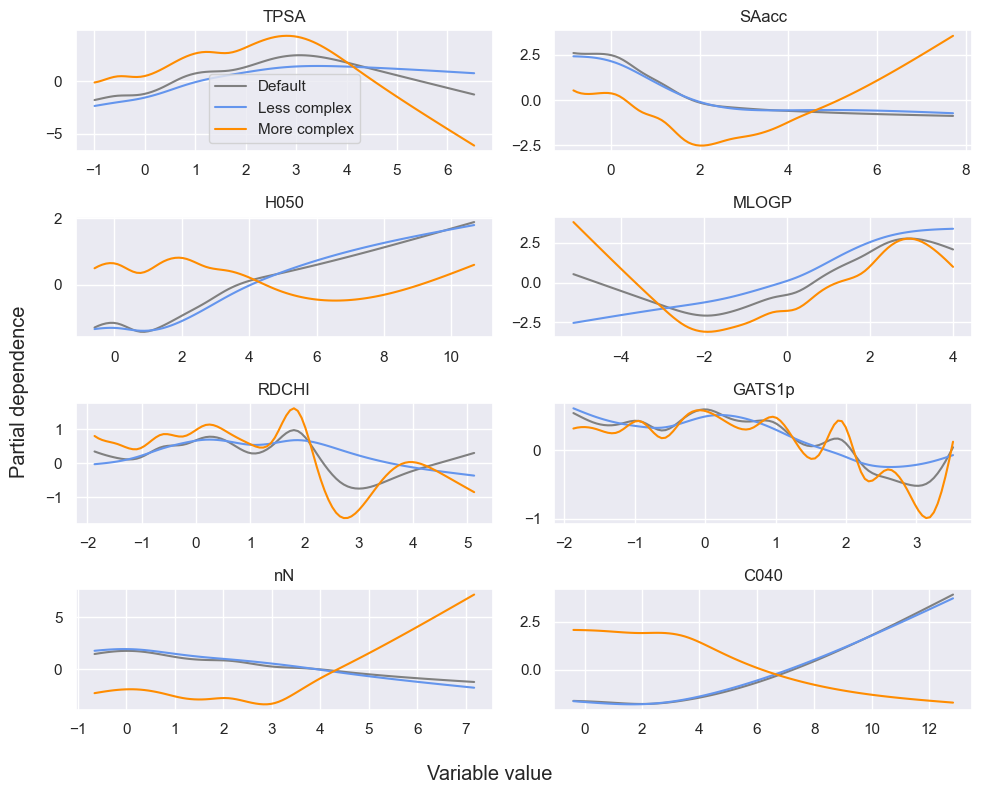

In [23]:
# Plot the partial dependence for each variable
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=figsize)
axes = axes.flatten()
for i, var in enumerate(variables):
    ax = axes[i]
    ax.set_title(f'{var}')
    
    XX = gam_default.generate_X_grid(term=i)
    
    # plot default gam
    ax.plot(XX[:, i], gam_default.partial_dependence(term=i, X=XX), 
            color="gray", 
            label="Default"
            )
    # Smooth gam
    ax.plot(XX[:, i], gam_smooth.partial_dependence(term=i, X=XX), 
            color="cornflowerblue", 
            label="Less complex"
            )
    # Complex gam
    ax.plot(XX[:, i], gam_complex.partial_dependence(term=i, X=XX), 
            color="darkorange", 
            label="More complex"
            )
    
   
axes[0].legend()
fig.supxlabel(f'Variable value')
fig.supylabel('Partial dependence')

fig.tight_layout()

From the figure above, we see how the degree of smoothing affects the shape of the partial dependece curves. Spesifically, the less complex model have indeed much smoother partial dependence curves, while the more complex model is in general more wiggly. 

Interestingly, the degree of smoothing can significantly alter the model response to some of the variables. For example, as `C040` increases, the default and smoother model prediction increases as well. In the complex model, however, the predictoin decrases. 

### (f) - Growing a healthy tree 🌱

We will start by growing a full tree, and then prune it.

In [24]:
# Fit a decision tree regressor without pruning
full_tree = DecisionTreeRegressor(random_state=2024)
full_tree.fit(df_train_i[variables], df_train_i[response])

# Calculate MSE on the training set
y_train_pred = full_tree.predict(df_train_i[variables])
mse_full_tree = mean_squared_error(df_train_i[response], y_train_pred)
training_results["Initial tree"] = mse_full_tree

# Predict and calculate MSE on the test set
y_test_pred = full_tree.predict(df_test_i[variables])
mse_full_tree = mean_squared_error(df_test_i[response], y_test_pred)
print(f"Initial MSE (no pruning): {mse_full_tree:.4f}")

test_results["Initial tree"] = mse_full_tree

Initial MSE (no pruning): 2.8874


Text(0.5, 1.0, 'Full Decision Tree')

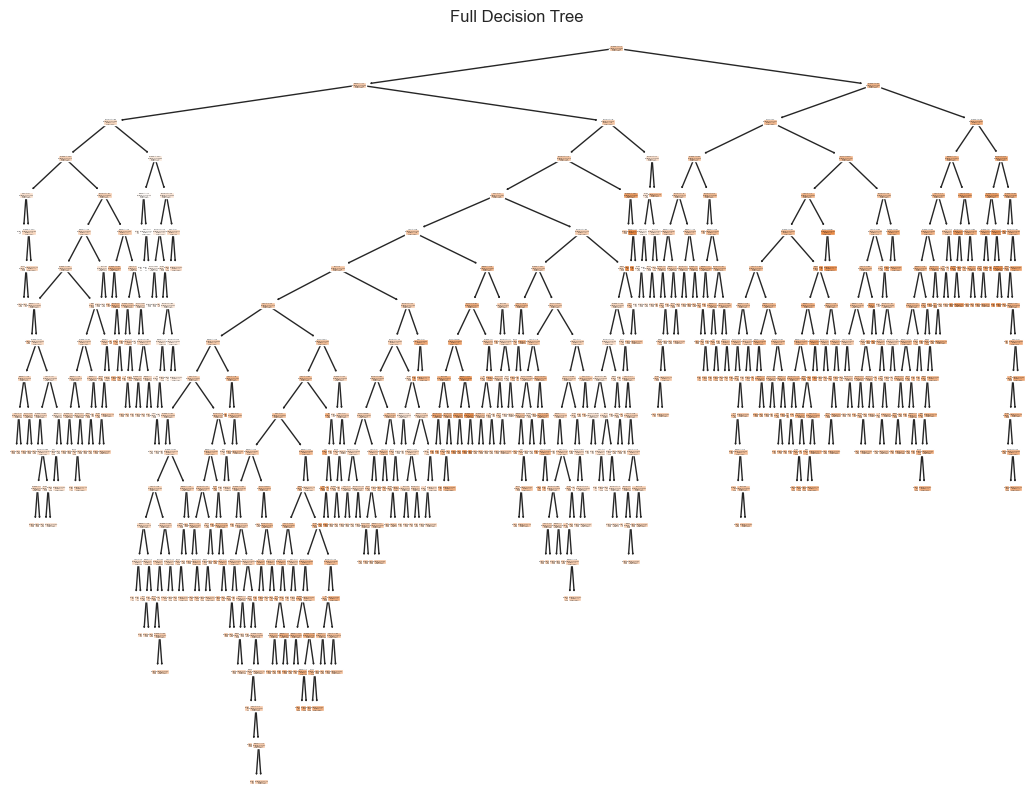

In [25]:
# Let's also plot the three
fig, ax = plt.subplots(figsize=(13, 10))

plot_tree(full_tree, filled=True, feature_names=variables, ax=ax)
ax.set_title("Full Decision Tree")

The full three is really growing all over the place, and is hard to interperet. So let's do some cost-complexity pruning! We will use sklearn functionality for this.

Text(0.5, 1.0, 'Cost-Complexity Pruning Path')

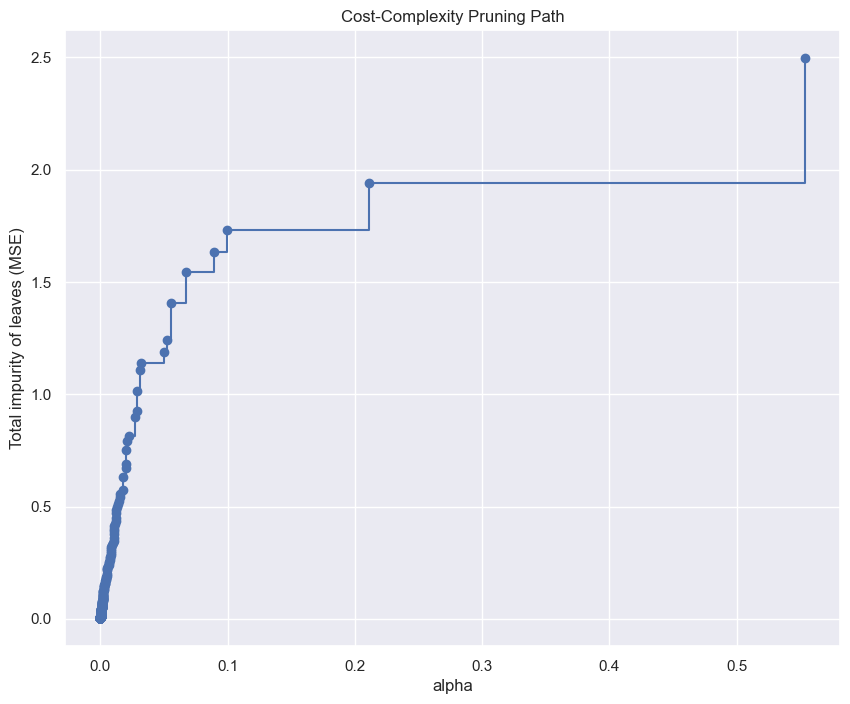

In [26]:
# Calculate the pruning path to find the optimal ccp_alpha
path = full_tree.cost_complexity_pruning_path(df_train_i[variables], df_train_i[response])
ccp_alphas = path.ccp_alphas  # Different alpha values for pruning
impurities = path.impurities  # Corresponding total leaf impurity for each alpha

# Plot the total impurity vs ccp_alpha
fig, ax = plt.subplots(figsize=figsize)
ax.plot(ccp_alphas, impurities, marker="o", drawstyle="steps-post")
ax.set_xlabel("alpha")
ax.set_ylabel("Total impurity of leaves (MSE)")
ax.set_title("Cost-Complexity Pruning Path")

The total impurity of leaves in a decision tree is the sum of the prediction errors at each leaf. As we see, the fully grown tree has low impurity. But this tree might overfit. We thus apply the pruned trees to the test set as well:

Optimal ccp_alpha: 0.0498
Test MSE with optimal pruned tree: 2.1186


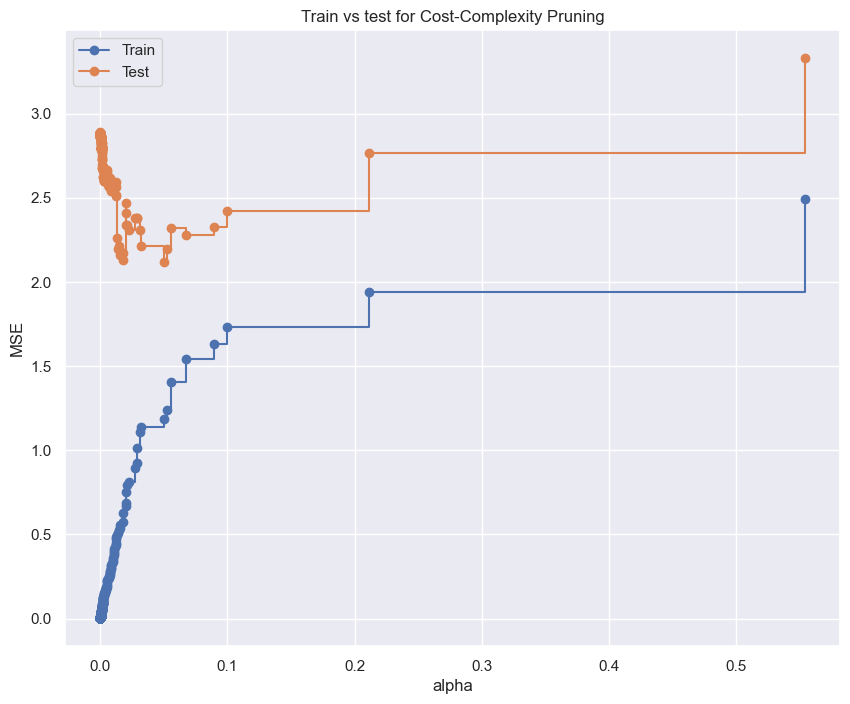

In [27]:
# Fit trees with different ccp_alpha values and evaluate performance
trees = []
train_mses = []
test_mses = []

for ccp_alpha in ccp_alphas:
    # Train tree with given ccp_alpha
    tree = DecisionTreeRegressor(random_state=2024, ccp_alpha=ccp_alpha)
    tree.fit(df_train_i[variables], df_train_i[response])
    
    # Store the tree
    trees.append(tree)
    
    # Evaluate the tree on the training and test sets
    y_train_pred = tree.predict(df_train_i[variables])
    y_test_pred = tree.predict(df_test_i[variables])
    
    train_mses.append(mean_squared_error(df_train_i[response], y_train_pred))
    test_mses.append(mean_squared_error(df_test_i[response], y_test_pred))

# Plot the training and test MSE vs ccp_alpha
fig, ax = plt.subplots(figsize=figsize)
ax.plot(ccp_alphas, train_mses, 
        marker="o", 
        label="Train", 
        drawstyle="steps-post"
        )
ax.plot(ccp_alphas, test_mses, 
        marker="o", 
        label="Test", 
        drawstyle="steps-post"
        )
ax.set_xlabel("alpha")
ax.set_ylabel("MSE")
ax.set_title("Train vs test for Cost-Complexity Pruning")
ax.legend()


# Find the best ccp_alpha that minimizes test MSE
optimal_alpha_index = np.argmin(test_mses)
optimal_ccp_alpha = ccp_alphas[optimal_alpha_index]

print(f"Optimal ccp_alpha: {optimal_ccp_alpha:.4f}")

# Fit the optimal tree
optimal_tree = DecisionTreeRegressor(random_state=2024, 
                                     ccp_alpha=optimal_ccp_alpha
                                     )
optimal_tree.fit(df_train_i[variables], df_train_i[response])

# Calculate MSE on the training set
y_train_pred_optimal = optimal_tree.predict(df_train_i[variables])
mse_optimal_tree = mean_squared_error(df_train_i[response], y_train_pred)
training_results["Pruned tree"] = mse_full_tree

# Predict on test set with the pruned tree
y_test_pred_optimal = optimal_tree.predict(df_test_i[variables])
mse_optimal_tree = mean_squared_error(
    df_test_i[response], y_test_pred_optimal)
print(f"Test MSE with optimal pruned tree: {mse_optimal_tree:.4f}")

test_results["Pruned tree"] = mse_optimal_tree

As we see from the test results for different alphas, a pruned tree preforms better than the full tree. This is because we avoid overfitting the model. This is reflected in a lower MSE on the test set for the pruned tree, compared to the full tere. 

Let's also plot the pruned tree.

Text(0.5, 1.0, 'Pruned Decision Tree')

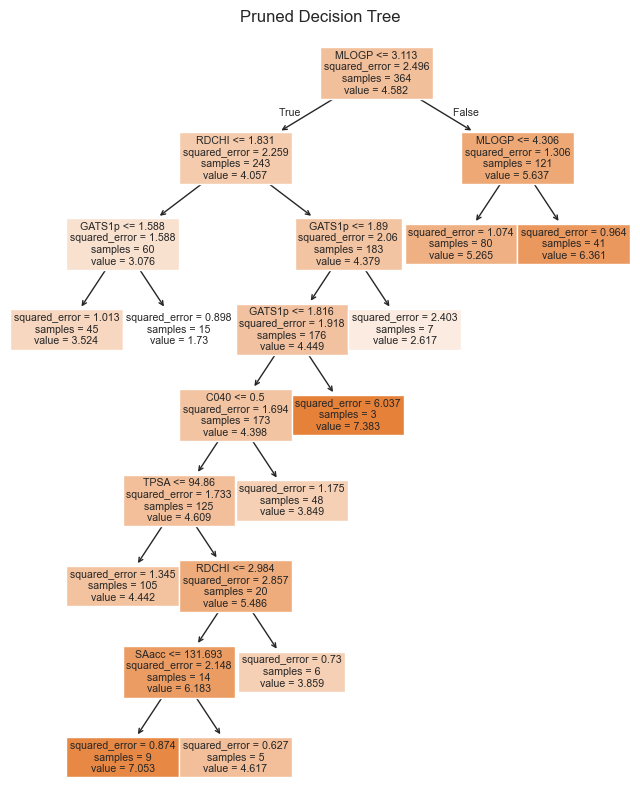

In [28]:
# Plot the pruned decision tree
fig, ax = plt.subplots(figsize=(8, 10))

plot_tree(optimal_tree, filled=True, feature_names=variables, ax=ax)
ax.set_title("Pruned Decision Tree")

After pruning, the decision tree is easier to interprete, and could easily be operated by hand.  

### (g) - Final evaluation of regression models 🎯

Lets plot both training and test MSE for the different models in one figure:

Text(0.5, 1.0, 'MSE for different regression models')

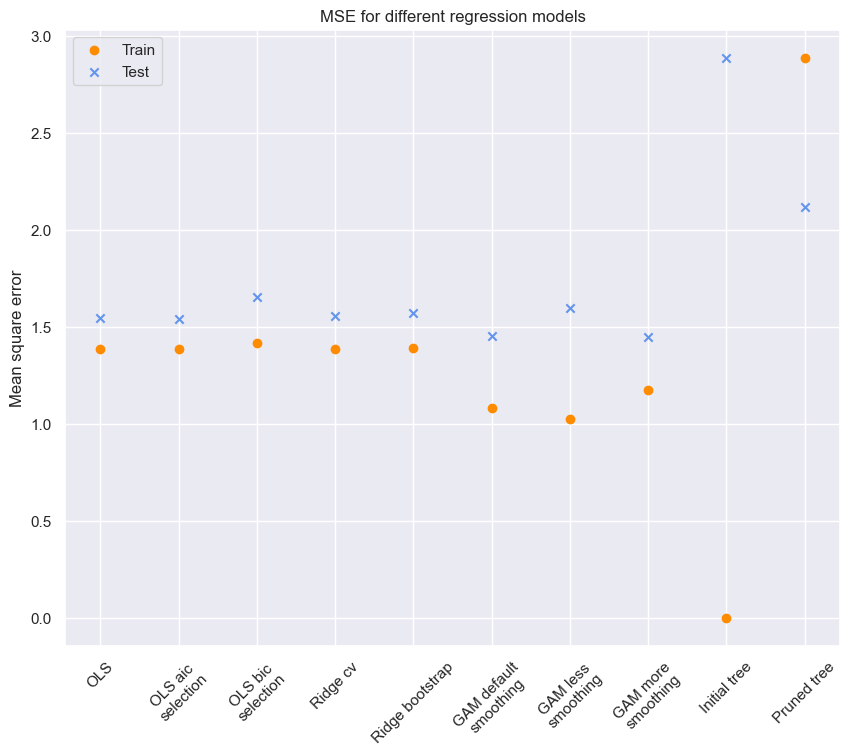

In [29]:
# plot both training and test errors from preceeding tasks
fig, ax = plt.subplots(figsize=figsize)
for keys, data in test_results.items():
    ax.scatter(keys, data, color="cornflowerblue", marker="x")
for keys, data in training_results.items():
    ax.scatter(keys, data, color="darkorange", marker="o")
    
ax.scatter(None, None, color="darkorange", marker="o", label="Train")
ax.scatter(None, None, color="cornflowerblue", marker="x", label="Test")
ax.legend()    
    
ax.tick_params(axis='x', labelrotation=45)
ax.set_ylabel("Mean square error")
ax.set_title("MSE for different regression models")


In general, we see that the test error is larger than the training error. The exeption is for the pruned tree, where the MSE decreases for the test set. I am not sure if this is a general feature for pruned trees, and would really like to hear from you. Both trees preform worse than the other models, however. 

All methods, exept for the trees, give quite similar test errors, indicating that any of these models would be a good fit. The less complex GAM models are preforming slightly better, which might suggest that there are some nonlinearities in the "true" model. 

## Problem 2 - Classification 🧬💉

We will now move on to classification, and to the dataset `pimaindiansdiabetes2.csv`. For this section we will use the error, defined as 1 - accuracy, as the evaluation score. We start by reading in the data and split it into a training and test set.

In [30]:
df = pd.read_csv("pimaindiansdiabetes2.csv")
df["diabetes"] = df["diabetes"].map({"pos":1,"neg":0})
df

,pregnant,glucose,pressure,triceps,insulin,mass,pedigree,age,diabetes
0,6,148.0,72.0,35.0,NaN,33.6,0.627,50,1
1,1,85.0,66.0,29.0,NaN,26.6,0.351,31,0
2,8,183.0,64.0,NaN,NaN,23.3,0.672,32,1
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101.0,76.0,48.0,180.0,32.9,0.171,63,0
764,2,122.0,70.0,27.0,NaN,36.8,0.340,27,0
765,5,121.0,72.0,23.0,112.0,26.2,0.245,30,0
766,1,126.0,60.0,NaN,NaN,30.1,0.349,47,1


In [31]:
# Define response and variables
response = "diabetes"
variables = [col for col in df.columns if col != response]

# Split dataset
df_train, df_test = train_test_split(df,test_size=1/3, random_state=2024)

# Dataframe for storing test results
test_results = {}

It turns out that the dataset contains quite many missing values, which we need to deal with somehow before training any classification models. One possibility is to simply drop all observations with missing values:

In [32]:
df_test = df_test.dropna()

df_dropna = df_train.dropna()
df_dropna

,pregnant,glucose,pressure,triceps,insulin,mass,pedigree,age,diabetes
527,3,116.0,74.0,15.0,105.0,26.3,0.107,24,0
487,0,173.0,78.0,32.0,265.0,46.5,1.159,58,0
591,2,112.0,78.0,50.0,140.0,39.4,0.175,24,0
457,5,86.0,68.0,28.0,71.0,30.2,0.364,24,0
486,1,139.0,62.0,41.0,480.0,40.7,0.536,21,0
...,...,...,...,...,...,...,...,...,...
539,3,129.0,92.0,49.0,155.0,36.4,0.968,32,1
640,0,102.0,86.0,17.0,105.0,29.3,0.695,27,0
608,0,152.0,82.0,39.0,272.0,41.5,0.270,27,0
506,0,180.0,90.0,26.0,90.0,36.5,0.314,35,1


By dropping missing values, we decrease the training set from 512 observations to 255 observations, which is a substantial reduction of ~50%. To avoid throwing out that much data, we will also test the k-nearest neighbour imputer in `scikit-learn`. This introduces another variable, i.e. the number of neighbours in the imputer. As for now, I will use a value of 5, and simply acknowledge that this is a variable that we could also tune. We will not touch the test set, as we wan to test our model againt the "true" data.  

In [33]:
# KNN imputation
knn_imputer = KNNImputer(n_neighbors=5)  # Use 5 nearest neighbors
df_imputed = df_train.copy()
df_imputed[variables] = knn_imputer.fit_transform(df_train[variables])

df_imputed

,pregnant,glucose,pressure,triceps,insulin,mass,pedigree,age,diabetes
184,4.0,141.0,74.0,27.4,152.4,27.6,0.244,40.0,0
702,1.0,168.0,88.0,29.0,210.6,35.0,0.905,52.0,1
527,3.0,116.0,74.0,15.0,105.0,26.3,0.107,24.0,0
487,0.0,173.0,78.0,32.0,265.0,46.5,1.159,58.0,0
78,0.0,131.0,75.2,42.4,205.8,43.2,0.270,26.0,1
...,...,...,...,...,...,...,...,...,...
539,3.0,129.0,92.0,49.0,155.0,36.4,0.968,32.0,1
640,0.0,102.0,86.0,17.0,105.0,29.3,0.695,27.0,0
608,0.0,152.0,82.0,39.0,272.0,41.5,0.270,27.0,0
506,0.0,180.0,90.0,26.0,90.0,36.5,0.314,35.0,1


### (a) - kNN classifier optimized using leave-one-out and 5-fold cross-validation 🏘️🏘️

We will fit a k-Nearest Neighbours classifier to our dataset, and tune the number of neighbours using both leave-one-out (loo) and 5-folds cross-validation. We will preform the procedure on both the dataset where NaNs where simply excluded, and on the imputed dataset.

In [34]:
def test_kNN_classifier(df_train, df_test, k_values):
    # Lists to store the errors for each k
    cv_5fold_errors = []
    cv_loo_errors = []
    test_errors = []

    # 5-Fold Cross-Validation
    kf = KFold(n_splits=5, shuffle=True, random_state=2024)

    # Leave-One-Out Cross-Validation
    loo = LeaveOneOut()

    # Iterate over different k values
    for k in k_values:
        # Initialize k-NN classifier with k neighbors
        knn = KNeighborsClassifier(n_neighbors=k)
        
        # 5-fold estimated error
        cv_5fold_accuracy = np.mean(cross_val_score(knn, df_train[variables], 
                                                    df_train[response], 
                                                    cv=kf, 
                                                    scoring='accuracy')
                                    )
        cv_5fold_error = 1 - cv_5fold_accuracy 
        cv_5fold_errors.append(cv_5fold_error)
        
        # Leave-One-Out estimated error
        cv_loo_accuracy = np.mean(cross_val_score(knn, df_train[variables], 
                                                  df_train[response], 
                                                  cv=loo, 
                                                  scoring='accuracy')
                                  )
        cv_loo_error = 1 - cv_loo_accuracy
        cv_loo_errors.append(cv_loo_error)
        
        # Fit the model on the training data and evaluate on the test set
        knn.fit(df_train[variables], df_train[response])
        y_test_pred = knn.predict(df_test[variables])
        test_error = 1 - accuracy_score(df_test[response], y_test_pred)
        test_errors.append(test_error)
        
    return cv_5fold_errors, cv_loo_errors, test_errors

In [35]:
# Define a range of candidate k values
k_values = range(1, 41)

# preform cross-validation and store errors
cv_5fold_errors_imputed, cv_loo_errors_imputed, test_errors_imputed = \
    test_kNN_classifier(df_imputed, df_test, k_values)
cv_5fold_errors_dropna, cv_loo_errors_dropna, test_errors_dropna = \
    test_kNN_classifier(df_dropna, df_test, k_values)

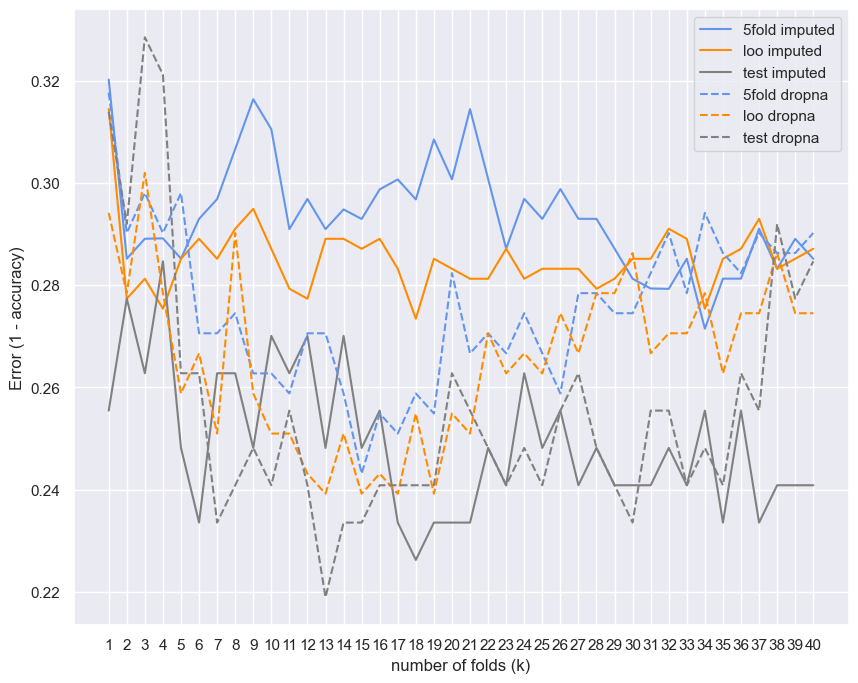

In [36]:
# plot error as function of k
fig, ax = plt.subplots(figsize=figsize)

error_lists = [cv_5fold_errors_imputed, cv_loo_errors_imputed, 
               test_errors_imputed, cv_5fold_errors_dropna, 
               cv_loo_errors_dropna, test_errors_dropna]
labels = ["5fold imputed", "loo imputed", "test imputed", 
          "5fold dropna", "loo dropna", "test dropna"]
linestyles = ["-"]*3 + ["--"]*3
colors = ["cornflowerblue", "darkorange", "gray"]*2

for i, errors in enumerate(error_lists):
    ls = linestyles[i]
    color = colors[i]
    label = labels[i]
    ax.plot(k_values, errors, ls = ls, color=color, label=label)
ax.legend()
ax.set_xticks(k_values)
ax.set_xlabel("number of folds (k)")
ax.set_ylabel("Error (1 - accuracy)")

best_k_loo = k_values[np.argmin(cv_loo_errors_dropna)]
test_results[f"kNN with k = {best_k_loo}\nfrom loo"] = \
    test_errors_dropna[np.argmin(cv_loo_errors_dropna)]

best_k_5fold = k_values[np.argmin(cv_5fold_errors_dropna)]
test_results[f"kNN with k = {best_k_5fold}\nfrom 5folds"] = \
    test_errors_dropna[np.argmin(cv_5fold_errors_dropna)]

In the plot above, the solid lines represent results for the imputed dataset, while the dashed lines are for the datasets which excluded observations with NaNs (dropna dataset). Blue lines represent 5-fold cross-validation error estimates, while orange lines are for leave-one-out cross-validation error estimates. Gray lines are for the test error. 

We see that the  test error is smaller than the estimated error from cross-validation, exept for the combination small ks and the dropna dataset. Also, in general, we see that loo estimates lower errors than 5-folds cross-validation. Thus, loo error mestimates are closer to the test error in this case. 

Further, the error curves exhibit an u-shape for the dropna dataset, indication a bias-variance tradeoff. We do not see such an u-shape for the imputed datast, exempt maybe some degree of reduced test errors around k = 18. 

It is also woth noting that the curves are quite spiky. Thus, our prediction for the optimal k might not be that sharp.

In the end, we get a smaller test error when preforming both the loo and 5fold cross-validation procedure on the dropna dataset. Also, the expected bias-variance tradeoff is much clearer for this dataset. Therefor, we will consentrate on this dataset for the remaining tasks. 

### (b) - GAM classifier 

We will now fit a GAM with splines to the dataset. We will do a grid search over the smoothing parameter `lam` to find the best model. In theory, variables with a complex relationship to the response will have an lower optimal `lam`, while variables with a higher optimal `lam` are less relevant and are smoothed out.

First, we standardize the values and train an inital model as a benchmark. Next, we define a parameter grid and preforms the grid search. It turned out that the grid search was a very slow process, so I had to limit the number of possible `lam` values to only three. After some testing, I ended up with the values 10, 100, 1000. I also tested lower values, but they where not selected. If you have suggestions for how to speed up the grid search, I would be very happy to hear about them!

In [37]:
# Standardize the variables
scaler = StandardScaler()
X_train = scaler.fit_transform(df_dropna[variables])
X_test = scaler.transform(df_test[variables])

In [38]:
# Fit a Logistic GAM with splines for each feature
gam_initial = LogisticGAM(s(0) + s(1) + s(2) + s(3) + 
                  s(4) + s(5) + s(6) + s(7)
                  ).fit(X_train, df_dropna[response])

# Predict on the test set
y_pred = gam_initial.predict(X_test)

# Calculate accuracy on the test set
accuracy = accuracy_score(df_test[response], y_pred)
print(f"Test error before tuning: {1-accuracy:.4f}")
test_results["Initial GAM"] = 1 - accuracy

Test error before tuning: 0.2628


In [39]:
gam = LogisticGAM(s(0) + s(1) + s(2) + s(3) + 
                  s(4) + s(5) + s(6) + s(7))

# Perform grid search for optimal smoothing parameters 
lam = np.array([10, 100, 1000])
lams = [lam] * 8

gam.gridsearch(X_train, df_dropna[response], 
               lam=lams, 
               progress=False
               )

# Print a summary of the fitted model (includes lambda values)
print(gam.summary())

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                     14.9346
Link Function:                        LogitLink Log Likelihood:                                  -102.2611
Number of Samples:                          255 AIC:                                              234.3914
                                                AICc:                                             236.6583
                                                UBRE:                                                2.966
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.3584
Feature Function                  Lam

/tmp/ipykernel_49455/3220501497.py:14: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


In [40]:
# Evaluate the tuned model on the test set
y_pred_tuned = gam.predict(X_test)
accuracy_tuned = accuracy_score(df_test[response], y_pred_tuned)
print(f"Test error after tuning: {1-accuracy_tuned:.4f}")

test_results["Tuned GAM"] = 1 - accuracy_tuned

Test error after tuning: 0.2336


As seen from the test error, tuning the model increases the preformance somewhat comparet to the initial model. 

From the table above, we can read of the optimal lambda parameter (of the three values included in the search) assigned to each variable. Again, a lower optimal lambda value indicates a more complex relationship between the variable and the response, while higher values indicate that a smoother realtionship is optimal. For example, the relation between s(4) and the response should be more complex than the relation between s(0) and the response, since s(4) has an optimal lambda value of 10, while s(0) has an much larger optimal lambda value of 1000. 

It can be helpful to plot the partial dependence for each variable to vizualise the effects that the variables have on the response:

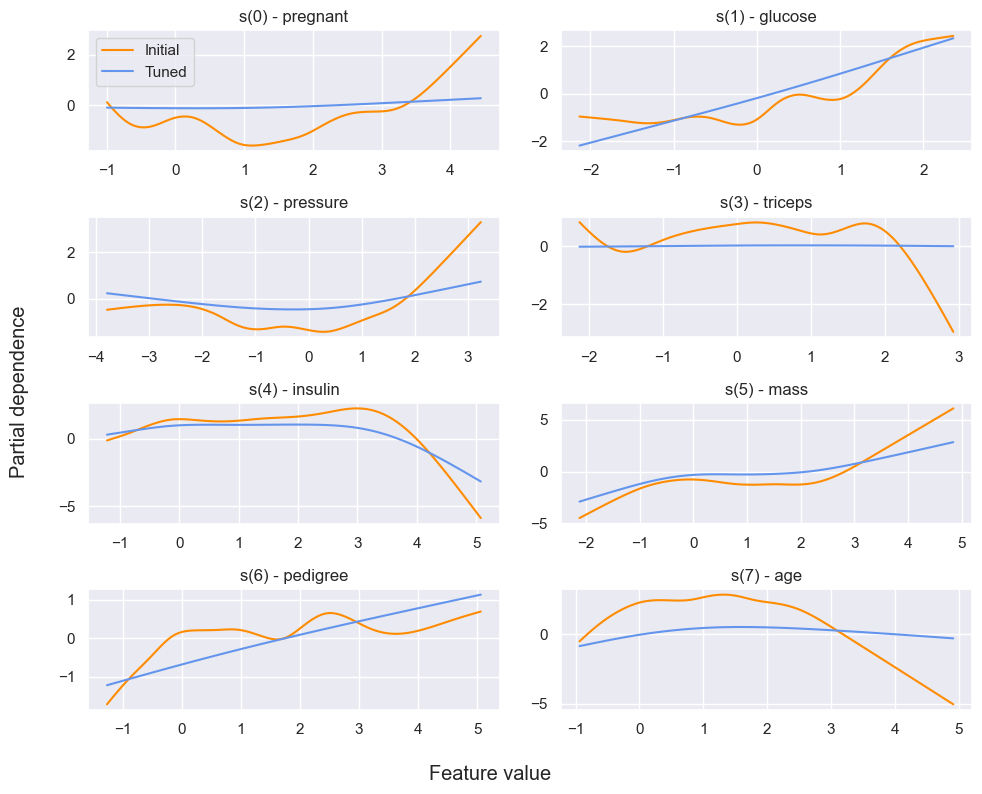

In [41]:
# Plot the partial dependence for each variable
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=figsize)
axes = axes.flatten()
for i, var in enumerate(variables):
    ax = axes[i]
    XX = gam.generate_X_grid(term=i)
    ax.plot(XX[:, i], gam_initial.partial_dependence(term=i, X=XX),
            label="Initial",
            color="darkorange")
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX), 
            label="Tuned",
            color="cornflowerblue")
    
    ax.set_title(f's({i}) - {var}')
axes[0].legend()
fig.supxlabel(f'Feature value')
fig.supylabel('Partial dependence')

fig.tight_layout()

Looking at the variables with a very high optimal lambda of 1000 (s(0), s(1), s(3) and s(6)), we see that the tuned partial dependence is almost linear. For s(0) and s(3), the slope is close to zero, indicating that there is little dependense on these variables in the response.

On the other hand, variables with a relatively low optimal lambda of 10 (s(4) and s(5)) exhibits a more complex relationship with the response. 

The rest are smoewhere inbetwen, and are almost linear, but with some curvature.

### (c) Growing trees 🌱🌱

Next up is growing classification trees.

#### (i)

We start by growing a single tree, and calculate the training and test error.

In [42]:
# Fit a single classification tree
tree = DecisionTreeClassifier(random_state=2024)
tree.fit(df_dropna[variables], df_dropna[response])

# Predict on training and test sets
y_train_pred_tree = tree.predict(df_dropna[variables])
y_test_pred_tree = tree.predict(df_test[variables])

# Calculate training and test accuracy
train_accuracy_tree = accuracy_score(df_dropna[response], y_train_pred_tree)
test_accuracy_tree = accuracy_score(df_test[response], y_test_pred_tree)

# Calculate errors
train_error_tree = 1 - train_accuracy_tree
test_error_tree = 1 - test_accuracy_tree

print(f"Classification tree - Training error: {train_error_tree:.4f}, \
    Test error: {test_error_tree:.4f}")

test_results["Tree"] = test_error_tree

Classification tree - Training error: 0.0000,     Test error: 0.2701


For the first time in this exercise, we get a perfect score of zero error! Sadly, this is for the training set, indicating tha the tree is overfitting the training data. This illustrates that trees can easily overfit, especially if we don't prone them. 

#### (ii)

Next up is fitting an ensamble of bagged trees:

In [43]:
# Fit an ensemble of bagged trees
bagged_trees = BaggingClassifier(estimator=DecisionTreeClassifier(), 
                                 n_estimators=100, 
                                 random_state=2024
                                 )
bagged_trees.fit(df_dropna[variables], df_dropna[response])

# Predict on training and test sets
y_train_pred_bagging = bagged_trees.predict(df_dropna[variables])
y_test_pred_bagging = bagged_trees.predict(df_test[variables])

# Calculate training and test accuracy
train_accuracy_bagging = accuracy_score(
    df_dropna[response], y_train_pred_bagging)
test_accuracy_bagging = accuracy_score(
    df_test[response], y_test_pred_bagging)

# Calculate errors
train_error_bagging = 1 - train_accuracy_bagging
test_error_bagging = 1 - test_accuracy_bagging

print(f"Bagged trees - Training error: {train_error_bagging:.4f}, \
    Test error: {test_error_bagging:.4f}")
test_results["Bagged trees"] = test_error_bagging

Bagged trees - Training error: 0.0000,     Test error: 0.2409


Again we get a perfect training score, meaning that the bagged tree also perfectly fit the training dataset. However, the test error goes down, indicating that the new bagged tree generalizes better.

#### (iii)

Finaly, we fit a random forest:

In [44]:
# Fit a random forest
random_forest = RandomForestClassifier(n_estimators=100, random_state=2024)
random_forest.fit(df_dropna[variables], df_dropna[response])

# Predict on training and test sets
y_train_pred_rf = random_forest.predict(df_dropna[variables])
y_test_pred_rf = random_forest.predict(df_test[variables])

# Calculate training and test accuracy
train_accuracy_rf = accuracy_score(df_dropna[response], y_train_pred_rf)
test_accuracy_rf = accuracy_score(df_test[response], y_test_pred_rf)

# Calculate errors
train_error_rf = 1 - train_accuracy_rf
test_error_rf = 1 - test_accuracy_rf

print(f"Random forest - Training error: {train_error_rf:.4f}, \
    Test error: {test_error_rf:.4f}")
test_results["Random forest"] = test_error_rf

Random forest - Training error: 0.0000,     Test error: 0.2336


As before, we get a perfect fit on the training data. For the test set, the error decreases a bit compared to the bagged tree, indicating that a random forest produces a more general tree than bagging. 

### (d) Neural Network 🧠

Finally, we will fit a neural network to the data. We will do a grid search with cross-validation to decide on the size of the network and the regularization term `alpha`. The values in the parameter grid are semi-educated guesses. I found the consept of double-decent that we talked about in the lectures facinating, so I made sure to include deep networks to see if these preformed better.

In [45]:
# Initialize the MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))  

# Fit the scaler on the training data and transform both the training and test data
X_train_scaled = scaler.fit_transform(df_dropna[variables])
X_test_scaled = scaler.transform(df_test[variables])

# Define the MLPClassifier
mlp = MLPClassifier(max_iter=1500, random_state=2024)

# Define the grid of hyperparameters to search
param_grid = {
    'hidden_layer_sizes': [(5,), (10,), (20,), (50,), (10, 10), (20, 10), 
                           (10, 20), (20 , 20),(10, 10, 10), (20, 20, 20),
                           (10, 10, 10, 10), (20, 20, 20, 20)], 
    'alpha': [0.0001, 0.001, 0.01, 0.1],  
}

# Perform GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(mlp, param_grid, 
                           cv=5, 
                           scoring='accuracy', 
                           verbose=1
                           )
grid_search.fit(X_train_scaled, df_dropna[response])

# Get the best hyperparameters from the grid search
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best parameters: {best_params}")
print(f"Best cross-validation error: {1-best_score:.4f}")

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_

# Predict on the test set
y_test_pred = best_model.predict(X_test_scaled)

# Calculate test accuracy
test_accuracy = accuracy_score(df_test[response], y_test_pred)
print(f"Test error:                  {1-test_accuracy:.4f}")
test_results["Neural Network"] = 1-test_accuracy

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best parameters: {'alpha': 0.001, 'hidden_layer_sizes': (20, 20, 20)}
Best cross-validation error: 0.2157
Test error:                  0.1679


In the end, the grid-search favoured one of the deeper, but not the deepest, network. The test error is also quite good compared to the previous methods. 

### (e) - Final evaluation of classifiers

It is time to have a look at the final results, and see if we can decide on the ideal model.

(0.0, 0.3)

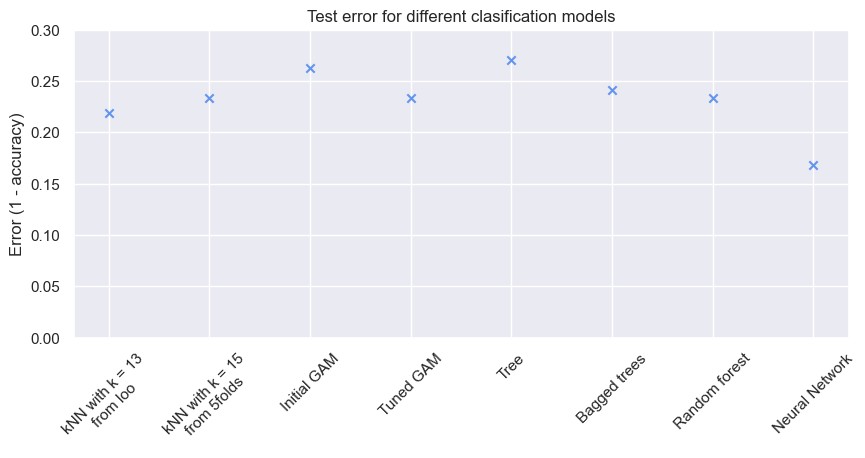

In [46]:
fig, ax = plt.subplots(figsize=(figsize[0], figsize[1]/2))
for keys, data in test_results.items():
    ax.scatter(keys, data, color="cornflowerblue", marker="x")
ax.tick_params(axis='x', labelrotation=45)
ax.set_ylabel("Error (1 - accuracy)")
ax.set_title("Test error for different clasification models")
ax.set_ylim(0, 0.3)

The figure above suggests that we should choose a neural network, if we were to choose a model purely based on the test error. However, the final choice of course depends on the application. If we want a more transparent model, any of the other models would be a better choice. 

So let's consider the other classes of models as well.

Starting with the kNN, we see that k = 13 gives the second best accuracy after NN. However, we also saw that the accuracy was quite sensitive to the choise of k, with a spikey dependence on k. 

Turning to the GAM models, the accuracy of the tuned GAM is comparable to the other top methods. However, the large optimal smoothing parameters suggests that a very complex model might not be needed. Tuning the GAM model requered the longest run-time (at least for my implementation), so I personally would avoid this method. 

Lastly, some of the tree models performed quite well, especally the random forest. Trees  have a very intuitive structure, and can be further improved by pruning. There also exists methods for handeling missing values in trees ([source](https://www.geeksforgeeks.org/handling-missing-data-in-decision-tree-models/)), which I would further investigate.

So, which model would I choose? It is hard to say no to the Neural Network, since it's very accurate. However, interpretability is importent when dealing with health data. Further, since the data contains quite a lot of missing data, I would choose a model that could be furher adjusted to handle such observations. Thus, I would choose the **random forest** model.  

## Problem 3 - Oral presentation 🌦️🌍

Title : **Combining Neural Networks and Physics for Weather and Climate Prediction**

Abstract : Traditionally, General Circulation Models (GCMs) built on a physical understanding of the earth system have been the standard for weather forecasting and climate predictions. More recently, pure Machine Learning (ML) models have been applied to these tasks with some success. In this talk, I will present a new method that combines GCMs with ML, which, in certain cases, outperforms both traditional GCMs and pure ML models.  I will focus on how physical models and ML models can be combined, and on the advantages and caviats of a hybrid model. I will base my presentation on the paper *Neural General Circulation Models for Weather and Climate*, published this year.

Reference : https://doi.org/10.48550/arXiv.2311.07222